# Models Comparison | proximity-quadrotor-learning

https://github.com/idsia-robotics/proximity-quadrotor-learning

## Settings

In [ ]:
################################
### KNOWN IMPORTS
######

import math
import os
import time
import errno
import random
import sys
import gc
from datetime import datetime

# %tensorflow_version 1.x
import tensorflow as tf

# when importing keras, please notice:
#   https://stackoverflow.com/a/57298275/10866825
#   https://www.pyimagesearch.com/2019/10/21/keras-vs-tf-keras-whats-the-difference-in-tensorflow-2-0/

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# !pip install resnet
# import resnet as kr

import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.metrics

import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

# -- for GradCAM
!pip install tf-keras-vis
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from matplotlib import cm


################################
### PATHS
######

# this file goes into the 'PROJECT_ROOT/src/' folder to work properly with the following paths

try:
  import google.colab
  IN_COLAB = True
  from google.colab import drive
  from google.colab.patches import cv2_imshow
  drive.mount('/content/drive')
  %cd '/content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/'
except:
  IN_COLAB = False
  from cv2 import imshow as cv2_imshow


this_folder = os.path.realpath('.') # see https://stackoverflow.com/a/32711758/10866825 for details
lib_folder = os.path.join(this_folder, './lib/')
original_models_folder = os.path.join(this_folder, './../dev-models/_originals/') # Dario's original trained models (https://drive.switch.ch/index.php/s/Idsyf8WIwQpvRMF)
original_datasets_folder = os.path.join(this_folder, './../dev-datasets/_originals/') # Dario's original dataset (https://drive.switch.ch/index.php/s/8clDQNH645ZjWDD)
backgrounds_folder = os.path.join(this_folder, './../dev-datasets/_backgrounds/')
new_models_folder = os.path.join(this_folder, './../dev-models/')
new_datasets_folder = os.path.join(this_folder, './../dev-datasets/')
visualization_folder = os.path.join(this_folder, './../dev-visualization/')

dario_model_path = original_models_folder + 'v1_model_train_size_50000_rep_1.h5'
dario_train_path = original_datasets_folder + 'dario/v1_train.pickle'
dario_test_path = original_datasets_folder + 'dario/v1_test.pickle'



################################
### CUSTOM IMPORTS
######

sys.path.append(lib_folder)
import general_utils
import keras_utils

import importlib
importlib.reload(general_utils)
importlib.reload(keras_utils)

Mounted at /content/drive
/content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src


<module 'keras_utils' from '/content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./lib/keras_utils.py'>

## Models selection

In [ ]:
model_dario_name = '20200930_100322 53k_start08k_classic_simple_total53k'
model_dario_all, model_dario_vars = keras_utils.network_import_variants(new_models_folder + model_dario_name + '/', model_dario_name)
m1_name = 'arena'

Models imported from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-models/20200930_100322 53k_start08k_classic_simple_total53k/


In [ ]:
model_mask_path = new_models_folder + 'maskrcnn 20201020_131935 31k_start24k_skip12_bg20_retrainfrom24_total53k on 60 epochs/maskrcnn 20201020_131935 31k_start24k_skip12_bg20_retrainfrom24_total53k - v1_all_class_model.h5'
model_mask_all = tf.keras.models.load_model(model_mask_path)
print('Model imported from ' + model_mask_path)
m2_name = 'maskRCNN_20bg'

Model imported from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-models/maskrcnn 20201020_131935 31k_start24k_skip12_bg20_retrainfrom24_total53k on 60 epochs/maskrcnn 20201020_131935 31k_start24k_skip12_bg20_retrainfrom24_total53k - v1_all_class_model.h5


In [ ]:
# model_mask_name = 'maskrcnn 20201020_123514 31k_start24k_skip12_bg20_retrainfrom24_total53k'
# model_mask_all, model_mask_vars = keras_utils.network_import_variants(new_models_folder + model_mask_name + '/', model_mask_name)

## Performance comparison

In [ ]:
def evaluate_dataset_on_models(dataset_path, model1, model2, ds_name = 'default', m1_name = 'm1', m2_name = 'm2'):
  test_img, test_x, test_y, test_actual, _ = general_utils.get_dataset_from_pickle(dataset_path, dataset_keep_ratio = 1)
  print('\n')

  m1_metrics = model1.evaluate(test_x, test_y[4:8], batch_size=64, return_dict=True)
  m2_metrics = model2.evaluate(test_x, test_y[4:8], batch_size=64, return_dict=True)

  print('\n\n{} model metrics on {} test set: \n {}'.format(m1_name, ds_name, m1_metrics))
  print('\n\n{} model metrics on {} test set: \n {}'.format(m2_name, ds_name, m2_metrics))

### Assurance on the training set

In [ ]:
evaluate_dataset_on_models(dario_train_path, model_dario_all, model_mask_all, 'dario_train', m1_name, m2_name)

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-datasets/_originals/dario/v1_train.pickle
dataset original shape: (63726, 3)
dataset keep shape: 	(63726, 3)
img_data shape: 	(63726,)
x_data shape: 		(63726, 60, 108, 3)
y_data shape: 		(63726, 4)
odom_dataset shape: 	(63726, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (63726,)
y_data_for_network single classification variable (4:8) 	 (63726, 3)


996/996 [==============================] - 287s 288ms/step - loss: 2.4271 - x_class_loss: 0.5857 - y_class_loss: 0.6809 - z_class_loss: 0.5974 - w_class_loss: 0.5631 - x_class_accuracy: 0.8024 - y_class_accuracy: 0.7963 - z_class_accuracy: 0.8465 - w_class_accuracy: 0.8145


arena model metrics on dario_train test set: 
 {'loss': 0.9017535448074341, 'x_class_loss': 0.4542616009712219, '

In [ ]:
bg20_train_path = new_datasets_folder + 'MASKRCNN replace 31860 samples (start24000, skip12 = 2655) with 20 backgrounds - total 53100/20201020_091307_maskrcnn_replacebg_df53100_1of1.pickle'
evaluate_dataset_on_models(bg20_train_path, model_dario_all, model_mask_all, 'bg20_train', m1_name, m2_name)

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-datasets/MASKRCNN replace 31860 samples (start24000, skip12 = 2655) with 20 backgrounds - total 53100/20201020_091307_maskrcnn_replacebg_df53100_1of1.pickle
dataset original shape: (53100, 3)
dataset keep shape: 	(53100, 3)
img_data shape: 	(53100,)
x_data shape: 		(53100, 60, 108, 3)
y_data shape: 		(53100, 4)
odom_dataset shape: 	(53100, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (53100,)
y_data_for_network single classification variable (4:8) 	 (53100, 3)


830/830 [==============================] - 220s 265ms/step - loss: 0.8165 - x_class_loss: 0.2937 - y_class_loss: 0.1551 - z_class_loss: 0.1428 - w_class_loss: 0.2249 - x_class_accuracy: 0.8806 - y_class_accuracy: 0.9391 - z_class_accuracy: 0.9497 - w_class_accuracy: 0.9120


### Various test sets

In [ ]:
### Test set: Dario

evaluate_dataset_on_models(dario_test_path, model_dario_all, model_mask_all, 'dario', m1_name, m2_name)

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-datasets/_originals/dario/v1_test.pickle
dataset original shape: (11035, 3)
dataset keep shape: 	(11035, 3)
img_data shape: 	(11035,)
x_data shape: 		(11035, 60, 108, 3)
y_data shape: 		(11035, 4)
odom_dataset shape: 	(11035, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (11035,)
y_data_for_network single classification variable (4:8) 	 (11035, 3)


173/173 [==============================] - 45s 259ms/step - loss: 3.8887 - x_class_loss: 0.9684 - y_class_loss: 1.0010 - z_class_loss: 0.8086 - w_class_loss: 1.1107 - x_class_accuracy: 0.7190 - y_class_accuracy: 0.7482 - z_class_accuracy: 0.8082 - w_class_accuracy: 0.6832


arena model metrics on dario test set: 
 {'loss': 2.5170300006866455, 'x_class_loss': 0.6581394076347351, 'y_class_

In [ ]:
### Test set: bg20

bg20_path = new_datasets_folder + 'MASKRCNN replace 11030 samples TEST (start0, skip10 = 1103) with 20 backgrounds - total 22060/20201022_133340_maskrcnn_replacebg_df22060_1of1.pickle'
evaluate_dataset_on_models(bg20_path, model_dario_all, model_mask_all, 'bg20', m1_name, m2_name)

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-datasets/MASKRCNN replace 11030 samples TEST (start0, skip10 = 1103) with 20 backgrounds - total 22060/20201022_133340_maskrcnn_replacebg_df22060_1of1.pickle
dataset original shape: (22060, 3)
dataset keep shape: 	(22060, 3)
img_data shape: 	(22060,)
x_data shape: 		(22060, 60, 108, 3)
y_data shape: 		(22060, 4)
odom_dataset shape: 	(22060, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (22060,)
y_data_for_network single classification variable (4:8) 	 (22060, 3)


345/345 [==============================] - 92s 267ms/step - loss: 3.3258 - x_class_loss: 1.1621 - y_class_loss: 0.5472 - z_class_loss: 0.6137 - w_class_loss: 1.0028 - x_class_accuracy: 0.6366 - y_class_accuracy: 0.8369 - z_class_accuracy: 0.8317 - w_class_accuracy: 0.6847


In [ ]:
# ### Test set: green

# green_path = original_datasets_folder + 'dario/green_test.pickle'
# evaluate_dataset_on_models(green_path, model_dario_all, model_mask_all, 'green', m1_name, m2_name)

In [ ]:
### Test set: singlebg_room11

singlebg_room11_path = new_datasets_folder + 'MASKRCNN replace 11030 samples TEST (skip2) with single_room11 background - total 5515/20201022_131619_maskrcnn_replacebg_df5515_1of1.pickle'
evaluate_dataset_on_models(singlebg_room11_path, model_dario_all, model_mask_all, 'singlebg_room11', m1_name, m2_name)

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-datasets/MASKRCNN replace 11030 samples TEST (skip2) with single_room11 background - total 5515/20201022_131619_maskrcnn_replacebg_df5515_1of1.pickle
dataset original shape: (5515, 3)
dataset keep shape: 	(5515, 3)
img_data shape: 	(5515,)
x_data shape: 		(5515, 60, 108, 3)
y_data shape: 		(5515, 4)
odom_dataset shape: 	(5515, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (5515,)
y_data_for_network single classification variable (4:8) 	 (5515, 3)


87/87 [==============================] - 23s 265ms/step - loss: 6.0359 - x_class_loss: 1.6195 - y_class_loss: 2.0287 - z_class_loss: 0.7355 - w_class_loss: 1.6522 - x_class_accuracy: 0.5808 - y_class_accuracy: 0.6296 - z_class_accuracy: 0.8377 - w_class_accuracy: 0.6196


arena model metr

In [ ]:
### Test set: singlebg_room15

singlebg_room15_path = new_datasets_folder + 'MASKRCNN replace 11030 samples TEST (skip2) with single_room15 background - total 5515/20201022_131716_maskrcnn_replacebg_df5515_1of1.pickle'
evaluate_dataset_on_models(singlebg_room15_path, model_dario_all, model_mask_all, 'singlebg_room15', m1_name, m2_name)

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-datasets/MASKRCNN replace 11030 samples TEST (skip2) with single_room15 background - total 5515/20201022_131716_maskrcnn_replacebg_df5515_1of1.pickle
dataset original shape: (5515, 3)
dataset keep shape: 	(5515, 3)
img_data shape: 	(5515,)
x_data shape: 		(5515, 60, 108, 3)
y_data shape: 		(5515, 4)
odom_dataset shape: 	(5515, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (5515,)
y_data_for_network single classification variable (4:8) 	 (5515, 3)


87/87 [==============================] - 23s 260ms/step - loss: 3.8544 - x_class_loss: 1.4888 - y_class_loss: 0.6474 - z_class_loss: 0.6355 - w_class_loss: 1.0826 - x_class_accuracy: 0.6129 - y_class_accuracy: 0.8105 - z_class_accuracy: 0.8401 - w_class_accuracy: 0.6936


arena model metr

In [ ]:
### Test set: singlebg_room20

singlebg_room20_path = new_datasets_folder + 'MASKRCNN replace 11030 samples TEST (skip2) with single_room20 background - total 5515/20201022_131733_maskrcnn_replacebg_df5515_1of1.pickle'
evaluate_dataset_on_models(singlebg_room20_path, model_dario_all, model_mask_all, 'singlebg_room20', m1_name, m2_name)

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-datasets/MASKRCNN replace 11030 samples TEST (skip2) with single_room20 background - total 5515/20201022_131733_maskrcnn_replacebg_df5515_1of1.pickle
dataset original shape: (5515, 3)
dataset keep shape: 	(5515, 3)
img_data shape: 	(5515,)
x_data shape: 		(5515, 60, 108, 3)
y_data shape: 		(5515, 4)
odom_dataset shape: 	(5515, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (5515,)
y_data_for_network single classification variable (4:8) 	 (5515, 3)


87/87 [==============================] - 22s 257ms/step - loss: 5.5564 - x_class_loss: 1.2629 - y_class_loss: 0.8791 - z_class_loss: 1.2443 - w_class_loss: 2.1700 - x_class_accuracy: 0.6484 - y_class_accuracy: 0.7607 - z_class_accuracy: 0.6827 - w_class_accuracy: 0.5752


arena model metr

### Dataset inspection

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-datasets/MASKRCNN replace 11030 samples TEST (skip2) with single_room11 background - total 5515/20201022_131619_maskrcnn_replacebg_df5515_1of1.pickle
dataset original shape: (5515, 3)
dataset keep shape: 	(5515, 3)
img_data shape: 	(5515,)
x_data shape: 		(5515, 60, 108, 3)
y_data shape: 		(5515, 4)
odom_dataset shape: 	(5515, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (5515,)
y_data_for_network single classification variable (4:8) 	 (5515, 3)


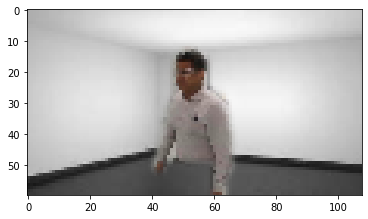

In [ ]:
test_img, test_x, test_y, test_actual, _ = general_utils.get_dataset_from_pickle(singlebg_room11_path, dataset_keep_ratio = 1)
plt.imshow(test_img[np.random.randint(len(test_img))])

## Complete overview
# step = 100
# ncols = 10
# nrows = 10
# size = (nrows * ncols)
# for start in range(0, len(test_img), step * size):
#   fix, ax = plt.subplots(nrows, ncols, figsize=(nrows*5, ncols*3), subplot_kw={'xticks': [], 'yticks': []})
#   end = start + step * size
#   for count, i in enumerate(range(start, end, step)):
#     ax[count//10, count%10].imshow(test_img[i])

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-datasets/MASKRCNN replace 11030 samples TEST (skip2) with single_room15 background - total 5515/20201022_131716_maskrcnn_replacebg_df5515_1of1.pickle
dataset original shape: (5515, 3)
dataset keep shape: 	(5515, 3)
img_data shape: 	(5515,)
x_data shape: 		(5515, 60, 108, 3)
y_data shape: 		(5515, 4)
odom_dataset shape: 	(5515, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (5515,)
y_data_for_network single classification variable (4:8) 	 (5515, 3)


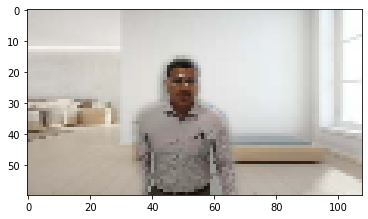

In [ ]:
test_img, test_x, test_y, test_actual, _ = general_utils.get_dataset_from_pickle(singlebg_room15_path, dataset_keep_ratio = 1)
plt.imshow(test_img[np.random.randint(len(test_img))])

## Complete overview
# step = 100
# ncols = 10
# nrows = 10
# size = (nrows * ncols)
# for start in range(0, len(test_img), step * size):
#   fix, ax = plt.subplots(nrows, ncols, figsize=(nrows*5, ncols*3), subplot_kw={'xticks': [], 'yticks': []})
#   end = start + step * size
#   for count, i in enumerate(range(start, end, step)):
#     ax[count//10, count%10].imshow(test_img[i])

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-datasets/MASKRCNN replace 11030 samples TEST (skip2) with single_room20 background - total 5515/20201022_131733_maskrcnn_replacebg_df5515_1of1.pickle
dataset original shape: (5515, 3)
dataset keep shape: 	(5515, 3)
img_data shape: 	(5515,)
x_data shape: 		(5515, 60, 108, 3)
y_data shape: 		(5515, 4)
odom_dataset shape: 	(5515, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (5515,)
y_data_for_network single classification variable (4:8) 	 (5515, 3)


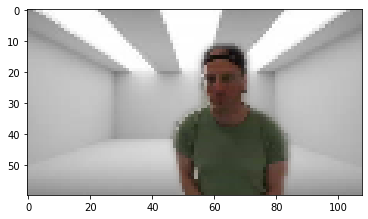

In [ ]:
test_img, test_x, test_y, test_actual, _ = general_utils.get_dataset_from_pickle(singlebg_room20_path, dataset_keep_ratio = 1)
plt.imshow(test_img[np.random.randint(len(test_img))])

## Complete overview
# step = 100
# ncols = 10
# nrows = 10
# size = (nrows * ncols)
# for start in range(0, len(test_img), step * size):
#   fix, ax = plt.subplots(nrows, ncols, figsize=(nrows*5, ncols*3), subplot_kw={'xticks': [], 'yticks': []})
#   end = start + step * size
#   for count, i in enumerate(range(start, end, step)):
#     ax[count//10, count%10].imshow(test_img[i])